# ANES


[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/anes_overton.ipynb)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [3]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [5]:
from utils import make_lowess, plot_series_lowess, decorate, values

<IPython.core.display.Javascript object>

In [6]:
def savefig(filename, **options):
    if "dpi" not in options:
        options["dpi"] = 300
    plt.savefig(filename, **options)

<IPython.core.display.Javascript object>

## Read the Data

[You can get the data here](https://electionstudies.org/data-center/anes-time-series-cumulative-data-file/) -- but you'll need to create an account.

In [7]:
df = pd.read_stata("anes_timeseries_cdf_stata_20220916.dta", convert_categoricals=False)
df.shape

(68224, 1030)

<IPython.core.display.Javascript object>

In [8]:
column_dict = {
    "VCF0004": "year",
    "VCF0803": "polviews",
    "VCF0301": "partyid",
    "VCF0302": "partyid3",
    "VCF0104": "sex",
    "VCF0101": "age",
    "VCF0009z": "wtsamp",
}

df.rename(columns=column_dict, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
recode_polviews = {
    1: "Liberal",
    2: "Moderate",
    3: "Conservative",
}
df["polviews3"] = df["VCF0804"].replace(recode_polviews)
df["polviews3"].value_counts()

/tmp/ipykernel_596595/1324274489.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["polviews3"] = df["VCF0804"].replace(recode_polviews)


polviews3
Conservative    15631
Moderate        12532
Liberal         10984
9.0              9568
0.0              4193
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
recode_sex = {
    1: "Male",
    2: "Female",
}
df["sex"].replace(recode_sex, inplace=True)
df["sex"].value_counts()

sex
Female    37390
Male      30612
0.0         211
3.0          11
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
df["wtsamp"].describe()

count    68224.000000
mean         1.039790
std          0.564906
min          0.021200
25%          0.896200
50%          1.000000
75%          1.000000
max          6.932929
Name: wtsamp, dtype: float64

<IPython.core.display.Javascript object>

In [12]:
values(df["year"])

,counts
values,
1948.0,662
1952.0,1899
1954.0,1139
1956.0,1762
1958.0,1450
1960.0,1181
1962.0,1297
1964.0,1571
1966.0,1291


<IPython.core.display.Javascript object>

In [13]:
values(df["age"])

,counts
values,
0.0,887
17.0,21
18.0,498
19.0,605
20.0,690
...,...
96.0,3
97.0,2
98.0,2


<IPython.core.display.Javascript object>

In [14]:
df["age"].replace(0, np.nan, inplace=True)

<IPython.core.display.Javascript object>

In [15]:
values(df["polviews"])

,counts
values,
0.0,2400
1.0,1229
2.0,4821
3.0,4934
4.0,12532
5.0,6567
6.0,7523
7.0,1541
9.0,11361


<IPython.core.display.Javascript object>

In [16]:
values(df["VCF0804"])

,counts
values,
0.0,4193
1.0,10984
2.0,12532
3.0,15631
9.0,9568
NaN,15316


<IPython.core.display.Javascript object>

In [17]:
values(df["partyid3"])

,counts
values,
1.0,14125
2.0,15856
3.0,2937
4.0,733
5.0,20437
8.0,133
9.0,244
NaN,13759


<IPython.core.display.Javascript object>

In [18]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby("year")
    samples = [resample_rows_weighted(group, column) for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

<IPython.core.display.Javascript object>

In [19]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, _ = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

<IPython.core.display.Javascript object>

In [20]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

<IPython.core.display.Javascript object>

In [21]:
subset = df.query("year >= 1972").copy()

<IPython.core.display.Javascript object>

In [22]:
sample = resample_by_year(subset, "wtsamp")
subset = sample

<IPython.core.display.Javascript object>

## Find Controversial Questions

This section explores the questions where we see the biggest difference in responses between liberals and conservatives.

In [23]:
df_con = subset.query('polviews3 == "Conservative"')
df_lib = subset.query('polviews3 == "Liberal"')

<IPython.core.display.Javascript object>

In [24]:
def compute_diff(col):
    con = df_con[col].dropna().value_counts()
    if len(con) == 0:
        return np.nan
    lib = df_lib[col].dropna().value_counts()
    value = con.idxmax()
    p_con = con[value] / con.sum()
    p_lib = lib.get(value, np.nan) / lib.sum()
    return abs(p_con - p_lib)

<IPython.core.display.Javascript object>

In [25]:
res = []
for col in subset.columns:
    diff = compute_diff(col)
    res.append((col, diff))

columns = ["name", "diff"]
candidates = (
    pd.DataFrame(res, columns=columns).dropna().sort_values(by="diff", ascending=False)
)
candidates

,name,diff
598,VCF0849,0.968694
155,VCF0303,0.600038
514,VCF0713,0.569138
504,VCF0704,0.534672
505,VCF0704a,0.534672
...,...,...
596,VCF0848,0.000215
672,VCF0929,0.000176
161,VCF0310,0.000030
73,VCF0131,0.000000


<IPython.core.display.Javascript object>

In [26]:
string_to_empty_dict = {key: "" for key in candidates["name"]}

<IPython.core.display.Javascript object>

Most variables that show a strong difference are questions about political parties and things like that.
I've identified the ones that ask about attitudes, beliefs, and policies.

In [27]:
candidate_dict = {
    "VCF0849": "lib or con",
    "VCF0303": "partyid",
    "VCF0713": "",
    "VCF9204": "",
    "VCF0704": "",
    "VCF0705": "",
    "VCF0704a": "",
    "VCF0706": "",
    "VCF9205": "",
    "VCF9027": "",
    "VCF0487": "",
    "VCF9209": "",
    "VCF0475": "",
    "VCF9212": "",
    "VCF0372": "",
    "VCF0360": "",
    "partyid3": "",
    "VCF9210": "",
    "VCF0734": "",
    "VCF9131": "LESS GOVERNMENT BETTER OR GOVERNMENT DO MORE",
    "VCF0709": "",
    "VCF0386": "",
    "VCF0373": "",
    "VCF0894": "FEDERAL SPENDING- WELFARE PROGRAMS",
    "VCF0481": "",
    "VCF0361": "",
    "VCF0700": "",
    "VCF0374": "",
    "VCF0493": "",
    "VCF0707": "",
    "VCF0736": "",
    "VCF9133": "GOVT TOO INVOLVED IN THINGS OR PROBLEMS REQUIRE",
    "VCF0876a": "LAW TO PROTECT HOMOSEXUALS AGAINST DISCRIMINATION",
    "VCF9238": "SHOULD THE GOVERNMENT MAKE IT MORE DIFFICULT OR EASIER TO BUY A GUN, OR SHOULD THE RULES STAY THE SAME AS THEY ARE NOW",
    "VCF0385b": "",
    "VCF0401": "",
    "VCF0370": "",
    "VCF0371": "",
    "VCF0853": "SHOULD BE MORE EMPHASIS ON TRADITIONAL VALUES",
    "VCF0878": "SHOULD GAYS/LESBIANS BE ABLE TO ADOPT CHILDREN",
    "VCF9228": "MUCH OR SOMEWHAT LARGER/SMALLER GAP IN INCOMES BETWEEN RICH AND POOR IN THE U.S. THAN 20 YEARS AGO",
    "VCF0867a": "AFFIRMATIVE ACTION IN HIRING/PROMOTION",
    "VCF0405": "",
    "VCF0359": "",
    "VCF9085": "",
    "VCF9132": "GOVT HANDLE ECONOMY OR FREE MARKET CAN HANDLE",
    "VCF0877a": "POSITION ON GAYS IN THE MILITARY",
    "VCF9237": "STRENGTH FAVOR/OPPOSE THE DEATH PENALTY FOR PERSONS CONVICTED OF MURDER",
    "VCF9236": "FAVOR OR OPPOSE THE DEATH PENALTY FOR PERSONS CONVICTED OF MURDER",
    "VCF9207": "",
    "VCF9275": "IN AMERICAN POLITICS, DO BLACKS HAVE TOO MUCH, ABOUT THE RIGHT AMOUNT OF, OR TOO LITTLE INFLUENCE",
    "partyid": "",
    "VCF0890": "FEDERAL SPENDING- PUBLIC SCHOOLS",
    "VCF9219": "",
    "VCF0358": "",
    "VCF1043b": "",
    "VCF9086": "",
    "VCF9213": "",
    "VCF0369": "",
    "VCF9211": "",
    "VCF9088": "",
    "VCF0833": "FAVOR OR OPPOSE EQUAL RIGHTS AMENDMENT",
    "VCF0406": "",
    "VCF0601": "APPROVE PARTICIPATION IN PROTESTS",
    "VCF0851": "NEWER LIFESTYLES CONTRIBUTE TO SOCIETY BREAKDOWN",
    "VCF0852": "SHOULD ADJUST VIEW OF MORAL BEHAVIOR TO CHANGES",
    "VCF0867": "AFFIRMATIVE ACTION IN HIRING/PROMOTION",
    "VCF0893": "FEDERAL SPENDING- THE HOMELESS",
    "VCF0846": "IS RELIGION IMPORTANT TO RESPONDENT",
    "VCF9241": "",
    "VCF1004": "",
    "VCF0738": "",
    "VCF0392": "",
    "VCF9215": "",
    "VCF0879a": "INCREASE OR DECREASE NUMBER OF IMMIGRANTS TO U.S. 4-CATEGORY",
    "VCF0889": "FEDERAL SPENDING- AIDS RESEARCH/FIGHT AIDS",
    "VCF9028": "",
    "VCF0876": "LAW TO PROTECT HOMOSEXUALS AGAINST DISCRIMINATION",
    "VCF9216": "",
    "VCF9249": "WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: INDEPENDENCE OR RESPECT FOR ELDERS",
    "VCF0828": "SHOULD GOVERNMENT CUT MILITARY SPENDING",
    "VCF0838": "WHEN SHOULD ABORTION BE ALLOWED",
    "VCF9247": "WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: OBEDIENCE OR SELF-RELIANCE",
    "VCF1042b": "",
    "VCF9227": "DOES R THINK THE DIFFERENCE IN INCOMES BETWEEN RICH AND POOR IN THE U.S. IS LARGER, SMALLER, OR ABOUT THE SAME AS 20 YEARS AGO",
    "VCF9040": "BLACKS SHOULD NOT HAVE SPECIAL FAVORS TO SUCCEED",
    "VCF0424": "",
    "VCF9246": "WHICH IS MORE IMPORTANT FOR A CHILD TO HAVE: CURIOSITY OR GOOD MANNERS",
    "VCF0318": "",
    "VCF0826": "DID U.S. DO RIGHT THING GETTING INVOLVED IN WAR (DIFFERENT WARS)",
    "VCF9047": "FEDERAL SPENDING- IMPROVE AND PROTECT THE ENVIRONMENT",
    "VCF9046": "FEDERAL SPENDING- FOOD STAMPS",
    "VCF0391b": "",
    "VCF0603": "APPROVE DEMONSTRATIONS",
    "VCF0602": "APPROVE CIVIL DISOBEDIENCE",
    "VCF0314": "",
    "VCF0808": "GUARANTEED JOBS AND INCOME",
    "VCF9214": "",
    "VCF9084": "",
    "VCF0380": "",
    "VCF9008": "",
    "VCF0877": "FAVOR OR OPPOSE GAYS IN THE MILITARY",
    "VCF0834": "WOMEN EQUAL ROLE SCALE",
    "VCF0387b": "",
    "VCF0866": "",
    "VCF9201": "",
    "VCF0817": "SCHOOL BUSING SCALE",
    "VCF9013": "SOCIETY SHOULD ENSURE EQUAL OPPORTUNITY TO SUCCEED",
    "VCF9014": "WE HAVE GONE TOO FAR PUSHING EQUAL RIGHTS",
    "VCF0738a": "",
    "VCF0402": "",
    "VCF9232": "FAVOR OR OPPOSE THE U.S. GOVERNMENT TORTURING PEOPLE WHO ARE SUSPECTED OF BEING TERRORISTS, TO TRY TO GET INFORMATION",
    "VCF0128": "",
    "VCF0425": "",
    "VCF9037": "GOVERNMENT SHOULD ENSURE FAIR JOBS FOR BLACKS",
    "VCF0363": "",
    "VCF9042": "BLACKS GOTTEN LESS THAN THEY DESERVE OVER THE PAST FEW YEARS",
    "VCF0365": "",
    "VCF9077": "PRESIDENT ON GOVERNMENT HEALTH INSURANCE SCALE",
    "VCF0215": "THERMOMETER",
    "VCF0471": "",
    "VCF0235": "",
    "VCF9051": "SCHOOL PRAYER ALLOWED 2-CATEGORY",
    "VCF0847": "HOW MUCH GUIDANCE FROM RELIGION",
    "VCF9017": "SHOULD WORRY LESS ABOUT HOW EQUAL PEOPLE ARE",
    "VCF1037b": "",
    "VCF0806": "GOVERNMENT HEALTH INSURANCE SCALE",
    "VCF0426": "",
    "VCF0357": "",
    "VCF0130": "",
    "VCF0711": "",
    "VCF0886": "FEDERAL SPENDING- POOR/POOR PEOPLE",
    "VCF9280": "",
    "VCF0442": "",
    "VCF9221": "",
    "VCF0387a": "",
    "VCF0815": "SEGREGATION OR DESEGREGATION",
    "VCF0837": "WHEN SHOULD ABORTION BE ALLOWED",
    "VCF0809": "GUARANTEED JOBS AND INCOME SCALE",
    "VCF0147": "",
    "VCF0212": "",
    "VCF1030b": "",
    "VCF0447": "",
    "VCF9235": "",
    "VCF9202": "",
    "VCF9041": "BLACKS MUST TRY HARDER TO SUCCEED",
    "VCF9014": "WE HAVE GONE TOO FAR PUSHING EQUAL RIGHTS",
    "VCF0381b": "",
    "VCF0830": "AID TO BLACKS SCALE",
    "VCF0443": "",
    "VCF0440": "",
    "VCF0816": "SHOULD GOVERNMENT ENSURE SCHOOL INTEGRATION",
    "VCF0319": "",
    "VCF9087": "",
    "VCF0146": "",
    "VCF0218": "",
    "VCF0356": "",
    "VCF1038": "",
    "VCF0860": "",
    "VCF0224": "",
    "VCF0355": "",
    "VCF0433": "",
    "VCF0845": "",
    "VCF9208": "",
    "VCF0985": "",
    "VCF1032": "",
    "VCF0888": "FEDERAL SPENDING- DEALING WITH CRIME",
    "VCF0427": "",
    "VCF9240": "",
    "VCF0315": "",
    "VCF0381a": "",
    "VCF9015": "BIG PROBLEM THAT NOT EVERYONE HAS EQUAL CHANCE",
    "VCF0892": "FEDERAL SPENDING- FOREIGN AID",
    "VCF9016": "NOT BIG PROBLEM IF SOME HAVE MORE CHANCE IN LIFE",
    "VCF0153b": "",
    "VCF0130a": "",
    "VCF9220": "",
    "VCF0606": "HOW MUCH DOES THE FEDERAL GOVERNMENT WASTE TAX MONEY",
    "VCF0508": "",
    "VCF0384b": "",
    "VCF0748": "",
    "VCF0339": "",
    "VCF9094": "",
    "VCF9078": "",
    "VCF0842": "ENVIRONMENTAL REGULATION SCALE",
    "VCF9231": "FAVOR OR OPPOSE PLACING LIMITS ON IMPORTS TO PROTECT AMERICAN JOBS",
    "VCF0891": "FEDERAL SPENDING- FIN AID FOR COLLEGE STUDENTS",
    "VCF0233": "",
    "VCF0153a": "",
    "VCF0368": "",
    "VCF9081": "",
    "VCF9048": "FEDERAL SPENDING- SPACE/SCIENCE/TECHNOLOGY",
    "VCF9092": "",
    "VCF9039": "CONDITIONS MAKE IT DIFFICULT FOR BLACKS TO SUCCEED",
    "VCF9248": "WHICH IS MORE IMPORTANT FOR A CHILD TO BE: CONSIDERATE OR WELL-BEHAVED",
    "VCF9226": "",
    "VCF0396b": "",
    "VCF1020": "",
    "VCF0338": "",
    "VCF0829": "IS THE GOVERNMENT IN WASHINGTON TOO STRONG",
    "VCF0214": "",
}

<IPython.core.display.Javascript object>

## Grouping the questions

Some questions are already organized in groups -- like the following four questions about children, or the next group about government spending.

In [28]:
children_dict = {
    "VCF9249": "CHILDREN: INDEPENDENCE OR\nRESPECT FOR ELDERS",
    "VCF9246": "CHILDREN: CURIOSITY OR\nGOOD MANNERS",
    "VCF9247": "CHILDREN: SELF-RELIANCE OR\nOBEDIENCE",
    "VCF9248": "CHILDREN: CONSIDERATE OR\nWELL-BEHAVED",
}

<IPython.core.display.Javascript object>

In [29]:
spending_dict = {
    "VCF0886": "POOR PEOPLE",
    "VCF0887": "CHILD CARE",
    "VCF0888": "DEALING WITH CRIME",
    "VCF0889": "AIDS RESEARCH/FIGHT AIDS",
    "VCF0890": "PUBLIC SCHOOLS",
    "VCF0891": "FIN AID FOR COLLEGE STUDENTS",
    "VCF0892": "FOREIGN AID",
    "VCF0893": "THE HOMELESS",
    "VCF0894": "WELFARE PROGRAMS",
    # 'VCF9046': 'FOOD STAMPS',  limited years
    "VCF9047": "IMPROVE AND PROTECT THE ENVIRONMENT",
    "VCF9048": "SPACE/SCIENCE/TECHNOLOGY",
    "VCF9049": "SOCIAL SECURITY",
    # 'VCF9050': 'ASSISTANCE TO BLACKS',  limited years
}

<IPython.core.display.Javascript object>

I selected these questions because the sounded likely to elicit different responses from conservatives and liberals, but it turns out they don't.

In [30]:
nodiff_dict = {
    # first three asked over a short period
    #'VCF0601': 'APPROVE PARTICIPATION\nIN PROTESTS',
    #'VCF0602': 'APPROVE CIVIL DISOBEDIENCE',
    #'VCF0603': 'APPROVE DEMONSTRATIONS',
    "VCF0604": "TRUST THE FEDERAL GOVERNMENT\nTO DO WHAT IS RIGHT",
    "VCF0605": "FEDERAL GOVERNMENT RUN BY FEW INTERESTS\nOR FOR THE BENEFIT OF ALL",
    "VCF0607": "HOW MANY GOVERNMENT OFFICIALS\nARE SMART",
    "VCF0608": "HOW MANY GOVERNMENT OFFICIALS\nARE CROOKED",
    "VCF0609": "GOVERNMENT OFFICIALS CARE\nWHAT PEOPLE LIKE YOU THINK",
}

<IPython.core.display.Javascript object>

In [31]:
govt_dict = {
    "VCF0606": "HOW MUCH DOES THE FEDERAL\nGOVERNMENT WASTE TAX MONEY",
    "VCF9133": "GOVT TOO INVOLVED IN THINGS",
    "VCF9131": "LESS GOVERNMENT BETTER OR\nGOVERNMENT DO MORE",
    "VCF9132": "GOVT HANDLE ECONOMY OR\nFREE MARKET CAN HANDLE",
    # only asked in two years
    # 'VCF9134': 'MORE IMPORTANT TO BE\nCOOPERATIVE OR SELF-RELIANT'
}

<IPython.core.display.Javascript object>

Questions about [moral foundations](https://en.wikipedia.org/wiki/Moral_foundations_theory) elicit big differences.

In [32]:
moral_dict = {
    "VCF0853": "SHOULD BE MORE EMPHASIS\nON TRADITIONAL VALUES",
    "VCF0851": "NEWER LIFESTYLES CONTRIBUTE\nTO SOCIETY BREAKDOWN",
    "VCF0852": "SHOULD ADJUST VIEW OF\nMORAL BEHAVIOR TO CHANGES",
    "VCF0854": "SHOULD BE TOLERANT OF\nDIFFERENTMORAL STANDARDS",
}

<IPython.core.display.Javascript object>

In [33]:
equality_dict = {
    "VCF9013": "SOCIETY SHOULD ENSURE EQUAL\nOPPORTUNITY TO SUCCEED",
    "VCF9014": "WE HAVE GONE TOO FAR\nPUSHING EQUAL RIGHTS",
    "VCF9015": "BIG PROBLEM THAT NOT\nEVERYONE HAS EQUAL CHANCE",
    "VCF9016": "NOT BIG PROBLEM IF\nSOME HAVE MORE CHANCE IN LIFE",
    "VCF9017": "SHOULD WORRY LESS ABOUT\nHOW EQUAL PEOPLE ARE",
    "VCF9018": "FEWER PROBLEMS IF\nEVERYONE TREATED EQUALLY",
}

<IPython.core.display.Javascript object>

But I am mostly interested in questions related to concrete public policies, as opposed to abstract philosophies.

I also tried to find questions that overlap as much as possible with the 15 questions I used in Chapter 12.

In [34]:
policy_dict = {
    "VCF0876": "LAW TO PROTECT HOMOSEXUALS AGAINST DISCRIMINATION",
    "VCF0877": "FAVOR OR OPPOSE GAYS IN THE MILITARY",
    "VCF0878": "SHOULD GAYS/LESBIANS BE ABLE TO ADOPT CHILDREN",
    "VCF0879a": "INCREASE OR DECREASE NUMBER OF IMMIGRANTS TO U.S.",
    "VCF9238": "MORE DIFFICULT OR EASIER TO BUY A GUN",
    "VCF9236": "FAVOR OR OPPOSE THE DEATH PENALTY FOR MURDER",
    # limited years
    # 'VCF9232': 'TORTURING PEOPLE WHO ARE SUSPECTED OF BEING TERRORISTS',
    "VCF9231": "LIMITS ON IMPORTS TO PROTECT AMERICAN JOBS",
    # not much diff
    # 'VCF9230': 'ENCOURAGE OR DISCOURAGE REPLACE U.S. WORKERS WITH FOREIGN WORKERS',
    # 'VCF0823': 'BETTER OFF IF U.S. UNCONCERNED WITH REST OF WORLD',
    "VCF0838": "WHEN SHOULD ABORTION BE ALLOWED",
    "VCF9043": "SCHOOL PRAYER ALLOWED",
    "VCF0816": "SHOULD GOVERNMENT ENSURE SCHOOL INTEGRATION",
    "VCF9037": "SHOULD GOVERNMENT ENSURE FAIR JOBS FOR BLACKS",
    "VCF0867a": "AFFIRMATIVE ACTION IN HIRING/PROMOTION",
}

<IPython.core.display.Javascript object>

In [35]:
scale_dict = {
    "VCF0842": "ENVIRONMENTAL REGULATION SCALE",
    "VCF0843": "DEFENSE SPENDING SCALE",
    # limited years
    # 'VCF0844': 'HOW WILLING SHOULD U.S. BE TO USE MILITARY FORCE',
    "VCF0806": "GOVERNMENT HEALTH INSURANCE SCALE",
}

<IPython.core.display.Javascript object>

In [36]:
issue_dict = {**spending_dict, **scale_dict}
issue_dict = policy_dict

<IPython.core.display.Javascript object>

In [37]:
issue_names = [name.capitalize() for name in issue_dict.values()]
len(issue_names)

12

<IPython.core.display.Javascript object>

## Data cleaning

The following sections clean the data, primarily by replacing special codes for unasked, unanswered, or "don't know" with NaN.

In [38]:
for col in scale_dict:
    print(f"'{col}': [1, 2],")
    subset[col].replace([8, 9, 0], np.nan, inplace=True)

'VCF0842': [1, 2],
'VCF0843': [1, 2],
'VCF0806': [1, 2],


<IPython.core.display.Javascript object>

In [39]:
for col in policy_dict:
    print(f"'{col}': [1],")
    subset[col].replace([7, 8, 9, 0, -7, -8, -9], np.nan, inplace=True)

'VCF0876': [1],
'VCF0877': [1],
'VCF0878': [1],
'VCF0879a': [1],
'VCF9238': [1],
'VCF9236': [1],
'VCF9231': [1],
'VCF0838': [1],
'VCF9043': [1],
'VCF0816': [1],
'VCF9037': [1],
'VCF0867a': [1],


<IPython.core.display.Javascript object>

In [40]:
for i in range(1, 5):
    col = f"VCF085{i}"
    print(col)
    subset[col].replace([8, 9, 0], np.nan, inplace=True)

VCF0851
VCF0852
VCF0853
VCF0854


<IPython.core.display.Javascript object>

In [41]:
for i in range(1, 5):
    col = f"VCF085{i}"
    print(col)
    subset[col].replace([8, 9, 0], np.nan, inplace=True)

VCF0851
VCF0852
VCF0853
VCF0854


<IPython.core.display.Javascript object>

In [42]:
for i in range(3, 9):
    col = f"VCF901{i}"
    print(col)
    subset[col].replace([8, 9, 0], np.nan, inplace=True)

VCF9013
VCF9014
VCF9015
VCF9016
VCF9017
VCF9018


<IPython.core.display.Javascript object>

In [43]:
for i in range(6, 10):
    col = f"VCF924{i}"
    print(col)
    subset[col].replace([-8, -9], np.nan, inplace=True)

VCF9246
VCF9247
VCF9248
VCF9249


<IPython.core.display.Javascript object>

In [44]:
for i in range(1, 10):
    col = f"VCF060{i}"
    print(col)
    subset[col].replace([0, 9], np.nan, inplace=True)

VCF0601
VCF0602
VCF0603
VCF0604
VCF0605
VCF0606
VCF0607
VCF0608
VCF0609


<IPython.core.display.Javascript object>

In [45]:
for i in range(1, 5):
    col = f"VCF913{i}"
    print(col)
    subset[col].replace([8, 9], np.nan, inplace=True)

VCF9131
VCF9132
VCF9133
VCF9134


<IPython.core.display.Javascript object>

In [46]:
for i in range(86, 95):
    col = f"VCF08{i}"
    print(f"'{col}': [3, 7],")
    subset[col].replace([8, 9], np.nan, inplace=True)

'VCF0886': [3, 7],
'VCF0887': [3, 7],
'VCF0888': [3, 7],
'VCF0889': [3, 7],
'VCF0890': [3, 7],
'VCF0891': [3, 7],
'VCF0892': [3, 7],
'VCF0893': [3, 7],
'VCF0894': [3, 7],


<IPython.core.display.Javascript object>

In [47]:
for i in range(46, 51):
    col = f"VCF90{i}"
    print(f"'{col}': [3, 7],")
    subset[col].replace([8, 9], np.nan, inplace=True)

'VCF9046': [3, 7],
'VCF9047': [3, 7],
'VCF9048': [3, 7],
'VCF9049': [3, 7],
'VCF9050': [3, 7],


<IPython.core.display.Javascript object>

In [48]:
values(subset["VCF9050"])

,counts
values,
1.0,2995
2.0,7311
3.0,2733
7.0,33
NaN,39836


<IPython.core.display.Javascript object>

In [49]:
conservative_values = {
    "VCF0601": [1],
    "VCF0602": [1],
    "VCF0603": [1],
    "VCF0604": [1, 2],
    "VCF0605": [2],
    "VCF0606": [1],
    "VCF0607": [1],
    "VCF0608": [1],
    "VCF0609": [1],
    "VCF0851": [1, 2],
    "VCF0852": [4, 5],
    "VCF0853": [1, 2],
    "VCF0854": [4, 5],
    "VCF9013": [3, 4, 5],
    "VCF9014": [1, 2],
    "VCF9015": [3, 4, 5],
    "VCF9016": [1, 2],
    "VCF9017": [1, 2],
    "VCF9018": [3, 4, 5],
    "VCF9131": [1],
    "VCF9132": [2],
    "VCF9133": [1],
    "VCF9134": [2],
    "VCF9246": [3],
    "VCF9247": [1],
    "VCF9248": [3],
    "VCF9249": [3],
    "VCF0886": [3, 7],
    "VCF0887": [3, 7],
    "VCF0888": [1],  # dealing with crime
    "VCF0889": [3, 7],
    "VCF0890": [3, 7],
    "VCF0891": [3, 7],
    "VCF0892": [3, 7],
    "VCF0893": [3, 7],
    "VCF0894": [3, 7],
    "VCF9046": [3, 7],
    "VCF9047": [3, 7],
    "VCF9048": [3, 7],
    "VCF9049": [3, 7],
    "VCF9050": [3, 7],
    "VCF0876": [5],
    "VCF0877": [5],
    "VCF0878": [5],
    "VCF0879a": [5],
    "VCF9238": [2, 3],
    "VCF9236": [1],
    "VCF9232": [1],
    "VCF9231": [1],
    "VCF9230": [2, 3],  # not much difference
    "VCF0838": [1, 2],
    "VCF9043": [3, 4],
    "VCF0816": [2],
    "VCF9037": [5],
    "VCF0818": [4, 5],
    "VCF0823": [1],
    "VCF0867a": [5],
    "VCF0842": [5, 6, 7],
    "VCF0843": [5, 6, 7],
    "VCF0806": [5, 6, 7],
}

<IPython.core.display.Javascript object>

## Analysis

In [50]:
def make_questions(df, issue_dict):
    questions = pd.DataFrame(dtype=float)

    for varname in issue_dict:
        questions[varname] = (
            df[varname].isin(conservative_values[varname]).astype(float)
        )
        null = subset[varname].isna()
        questions.loc[null, varname] = np.nan

    return questions

<IPython.core.display.Javascript object>

In [51]:
def add_column(df, column):
    return pd.concat([df, column], axis=1)

<IPython.core.display.Javascript object>

In [52]:
def make_time_series(df, questions):
    questions_year = add_column(questions, subset["year"])
    over_time = questions_year.groupby("year").mean() * 100
    return over_time

<IPython.core.display.Javascript object>

In [53]:
from scipy.stats import linregress


def find_slopes(over_time, issue_dict):
    res = []
    for column in over_time.columns:
        desc = issue_dict[column].replace("\n", " ").capitalize()
        series = over_time[column].dropna()
        result = linregress(series.index, series.values)
        res.append((column, result.slope, desc))

    columns = ["name", "slope", "desc"]
    return pd.DataFrame(res, columns=columns).sort_values(by="slope")

<IPython.core.display.Javascript object>

In [54]:
def plot_over_time(over_time, title="", lowess=False):
    for column in over_time.columns:
        if lowess:
            plot_series_lowess(over_time[column], color="C0", alpha=0.5, label="")
        else:
            over_time[column].dropna().plot(style=".-", alpha=0.5)

    decorate(
        xlabel="Year of survey",
        ylabel="Percent",
        title=title,
    )

<IPython.core.display.Javascript object>

In [55]:
def make_diff_table(questions, df, varname):
    augmented = pd.concat([questions, df[varname]], axis=1)
    table = augmented.groupby(varname).mean().transpose() * 100
    return table

<IPython.core.display.Javascript object>

In [56]:
polview_names = ["Conservative", "Moderate", "Liberal"]

muted = sns.color_palette("muted", 5)
polview_color_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
marker_map = dict(zip(polview_names, ["s", "^", "o"]))
line_map = dict(zip(polview_names, [":", "-.", "--"]))

<IPython.core.display.Javascript object>

In [57]:
def plot_differences(table):
    plt.figure(figsize=(7, 4.5))
    plt.hlines(
        issue_names,
        table["Liberal"],
        table["Conservative"],
        color="gray",
        alpha=0.2,
    )

    for polview, color in reversed(polview_color_map.items()):
        x = table[polview]
        marker = marker_map[polview]
        plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polview)

    decorate(xlabel="Percent choosing conservative responses")
    plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>

In [58]:
from scipy.special import logit
from scipy.special import expit
from scipy.stats import norm
from empiricaldist import Pmf


def infer_missing(questions, df):
    ds = -logit(questions.mean().values)

    es = np.linspace(-6, 6, 21)
    E, D = np.meshgrid(es, ds)
    P = expit(E - D)
    Q = 1 - P
    ns = P.sum(axis=0)

    ps = norm.pdf(es, 0, 4)
    prior = Pmf(ps, es)
    prior.normalize()

    n, m = questions.shape
    size = n, m, len(es)
    res = np.empty(size)

    a = questions.fillna(2).astype(int).values
    ii, jj = np.nonzero(a == 0)
    res[ii, jj, :] = Q[jj]
    ii, jj = np.nonzero(a == 1)
    res[ii, jj, :] = P[jj]
    ii, jj = np.nonzero(a == 2)
    res[ii, jj, :] = 1

    product = res.prod(axis=1) * prior.values
    posterior = product / product.sum(axis=1)[:, None]
    con = (posterior * ns).sum(axis=1)

    answered = questions.notna().sum(axis=1)

    df["conservatism"] = pd.Series(con, df.index)
    df.loc[answered < 3, "conservatism"] = np.nan
    print(df["conservatism"].notna().sum())

<IPython.core.display.Javascript object>

In [59]:
def plot_con(df):
    series = df.groupby("year")["conservatism"].mean()

    plot_series_lowess(series, frac=0.7, color="C0", label="", plot_series=True)
    decorate(
        xlabel="Year of survey",
        ylabel="Number of conservative responses",
        title="Conservative responses vs year, all respondents",
    )

<IPython.core.display.Javascript object>

In [60]:
def plot_by_polviews(df):
    table = df.pivot_table(index="year", columns="polviews3", values="conservatism")

    columns = ["Conservative", "Moderate", "Liberal"]
    options = dict(frac=0.6, plot_series=True)

    for column in columns:
        plot_series_lowess(
            table[column],
            ls=line_map[column],
            color=polview_color_map[column],
            **options
        )

    # plot_series_lowess(series, ls="-", color="gray", alpha=0.5, label="overall")

    decorate(
        xlabel="Year",
        ylabel="Number of conservative responses",
        title="Conservative responses vs year, grouped by alignment",
    )

<IPython.core.display.Javascript object>

In [61]:
def plot_by_sex(df):
    table = df.pivot_table(index="year", columns="sex", values="conservatism")

    columns = ['Male', 'Female']
    options = dict(frac=0.6, plot_series=True)

    color_map = dict(zip(columns, ['C0', 'C1']))
    label_map = dict(zip(columns, ['Male', 'Female']))

    for column in columns:
        plot_series_lowess(table[column], 
                           color=color_map[column], 
                           label=label_map[column], 
                           **options)

    decorate(xlabel="Year of survey", 
             ylabel="Number of conservative responses",
             title="Conservative responses vs year, grouped by sex",
    )


<IPython.core.display.Javascript object>

In [62]:
questions = make_questions(subset, issue_dict)
over_time = make_time_series(subset, questions)
slopes = find_slopes(over_time, issue_dict)
diff_table = make_diff_table(questions, subset, "polviews3")
infer_missing(questions, subset)
slopes

34071


,name,slope,desc
2,VCF0878,-1.818581,Should gays/lesbians be able to adopt children
1,VCF0877,-1.197792,Favor or oppose gays in the military
0,VCF0876,-0.938155,Law to protect homosexuals against discrimination
3,VCF0879a,-0.838447,Increase or decrease number of immigrants to u.s.
9,VCF0816,-0.454179,Should government ensure school integration
5,VCF9236,-0.452679,Favor or oppose the death penalty for murder
8,VCF9043,-0.296690,School prayer allowed
11,VCF0867a,-0.250041,Affirmative action in hiring/promotion
7,VCF0838,-0.124896,When should abortion be allowed
6,VCF9231,0.039818,Limits on imports to protect american jobs


<IPython.core.display.Javascript object>

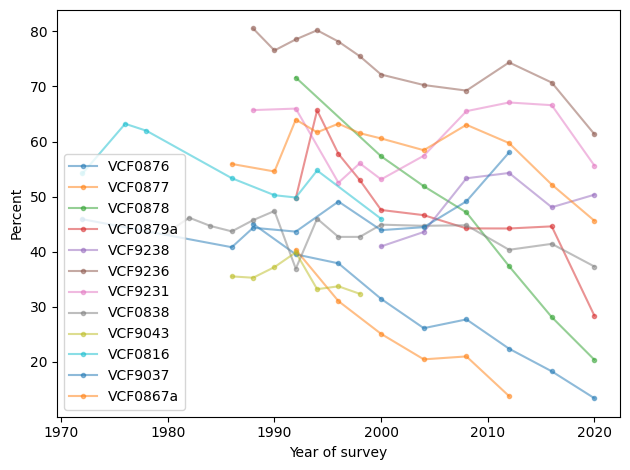

<IPython.core.display.Javascript object>

In [63]:
plot_over_time(over_time)
savefig("anes_overton1.png")

In [64]:
xtab = pd.crosstab(subset["year"], subset["VCF9037"], normalize="index") * 100
xtab

VCF9037,1.0,5.0
year,,
1972.0,54.117647,45.882353
1986.0,59.201141,40.798859
1988.0,55.664062,44.335938
1992.0,56.367162,43.632838
1996.0,50.902935,49.097065
2000.0,56.101844,43.898156
2004.0,55.555556,44.444444
2008.0,50.864422,49.135578
2012.0,41.983947,58.016053


<IPython.core.display.Javascript object>

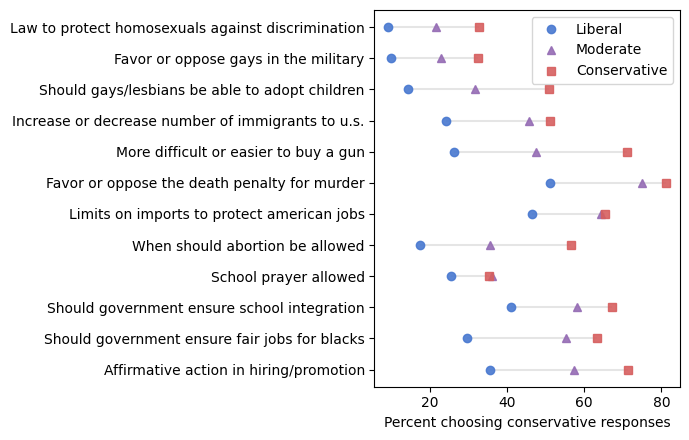

<IPython.core.display.Javascript object>

In [65]:
plot_differences(diff_table)
savefig("anes_overton2.png")

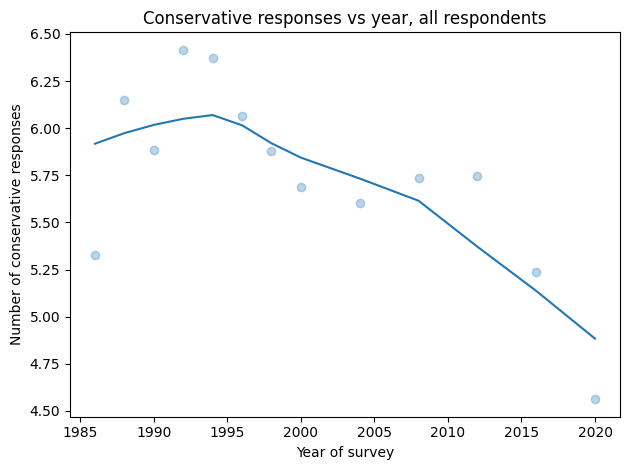

<IPython.core.display.Javascript object>

In [66]:
plot_con(subset)
savefig("anes_overton3.png")

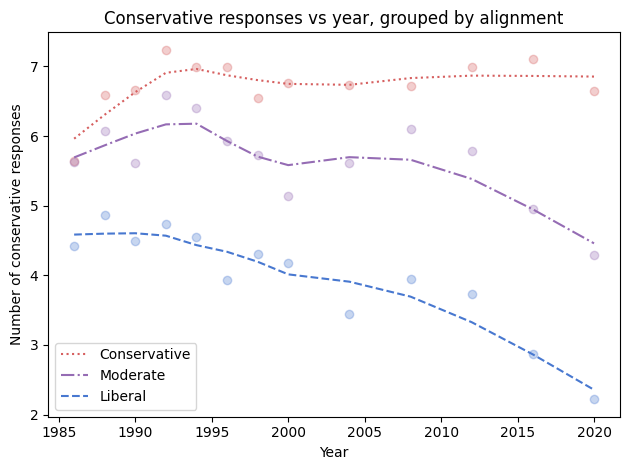

<IPython.core.display.Javascript object>

In [67]:
plot_by_polviews(subset)
savefig("anes_overton4.png")

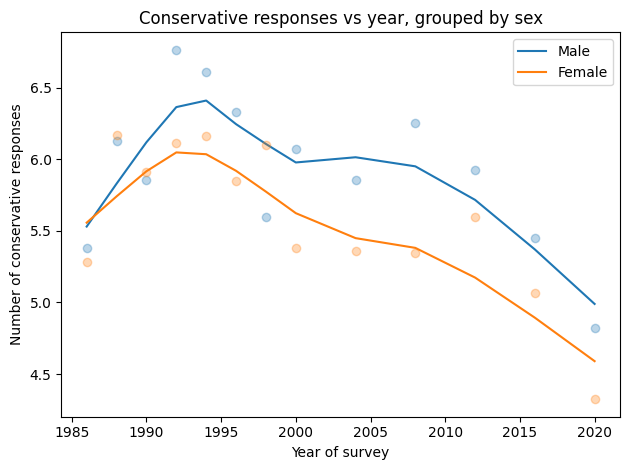

<IPython.core.display.Javascript object>

In [68]:
plot_by_sex(subset)
savefig("anes_overton5.png")

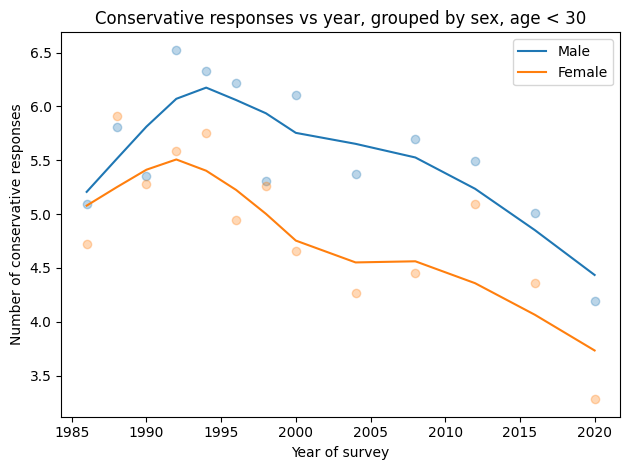

<IPython.core.display.Javascript object>

In [71]:
young = subset.query("age < 30")
plot_by_sex(young)
plt.title("Conservative responses vs year, grouped by sex, age < 30")
savefig("anes_overton6.png")